# Proyek Klasifikasi Gambar: Tomato Leaf Disease
- **Nama:** Achmad Fauzihan Bagus Sajiwo
- **Email:** achmadfauzihanbagussajiwo@gmail.com
- **ID Dicoding:** A296YBF008
- **Link Dataset:** https://www.kaggle.com/datasets/shylesh101/tomato-leaf-disease/data

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [37]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
import pickle

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


## Data Preparation

### Data Loading

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Buat direktori .kaggle
os.makedirs("/root/.kaggle", exist_ok=True)

# Copy file dari Google Drive
shutil.copy("/content/drive/MyDrive/kaggle/kaggle.json", "/root/.kaggle/kaggle.json")

# Ubah permission-nya
os.chmod("/root/.kaggle/kaggle.json", 600)

In [5]:
!kaggle datasets download -d aryashah2k/mango-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 57% 59.0M/103M [00:00<00:00, 612MB/s]
100% 103M/103M [00:00<00:00, 578MB/s] 


In [6]:
!unzip mango-leaf-disease-dataset.zip -d mango-leaf-disease-dataset

Archive:  mango-leaf-disease-dataset.zip
  inflating: mango-leaf-disease-dataset/Anthracnose/20211008_124249 (Custom).jpg  
  inflating: mango-leaf-disease-dataset/Anthracnose/20211008_124250 (Custom).jpg  
  inflating: mango-leaf-disease-dataset/Anthracnose/20211008_124252 (Custom).jpg  
  inflating: mango-leaf-disease-dataset/Anthracnose/20211008_124253 (Custom).jpg  
  inflating: mango-leaf-disease-dataset/Anthracnose/20211008_124256 (Custom).jpg  
  inflating: mango-leaf-disease-dataset/Anthracnose/20211008_124301 (Custom).jpg  
  inflating: mango-leaf-disease-dataset/Anthracnose/20211008_124302 (Custom).jpg  
  inflating: mango-leaf-disease-dataset/Anthracnose/20211008_124305 (Custom).jpg  
  inflating: mango-leaf-disease-dataset/Anthracnose/20211008_124306 (Custom).jpg  
  inflating: mango-leaf-disease-dataset/Anthracnose/20211008_124310 (Custom).jpg  
  inflating: mango-leaf-disease-dataset/Anthracnose/20211008_124312 (Custom).jpg  
  inflating: mango-leaf-disease-dataset/Anthra

In [7]:
# Baca gambar
img = cv2.imread('mango-leaf-disease-dataset/Anthracnose/20211008_124249 (Custom).jpg')

# Ukuran gambar
height, width, channels = img.shape
print("Lebar:", width)
print("Tinggi:", height)
print("Channels (RGB):", channels)

Lebar: 240
Tinggi: 320
Channels (RGB): 3


### Data Combine

In [8]:
data_dir = "mango-leaf-disease-dataset"

filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [9]:
df

,filepaths,labels
0,mango-leaf-disease-dataset/Gall Midge/IMG_2021...,Gall Midge
1,mango-leaf-disease-dataset/Gall Midge/IMG_2021...,Gall Midge
2,mango-leaf-disease-dataset/Gall Midge/IMG_2021...,Gall Midge
3,mango-leaf-disease-dataset/Gall Midge/IMG_2021...,Gall Midge
4,mango-leaf-disease-dataset/Gall Midge/IMG_2021...,Gall Midge
...,...,...
3995,mango-leaf-disease-dataset/Die Back/20211129_1...,Die Back
3996,mango-leaf-disease-dataset/Die Back/20211129_1...,Die Back
3997,mango-leaf-disease-dataset/Die Back/20211129_1...,Die Back
3998,mango-leaf-disease-dataset/Die Back/20211129_1...,Die Back


### Data Visualization

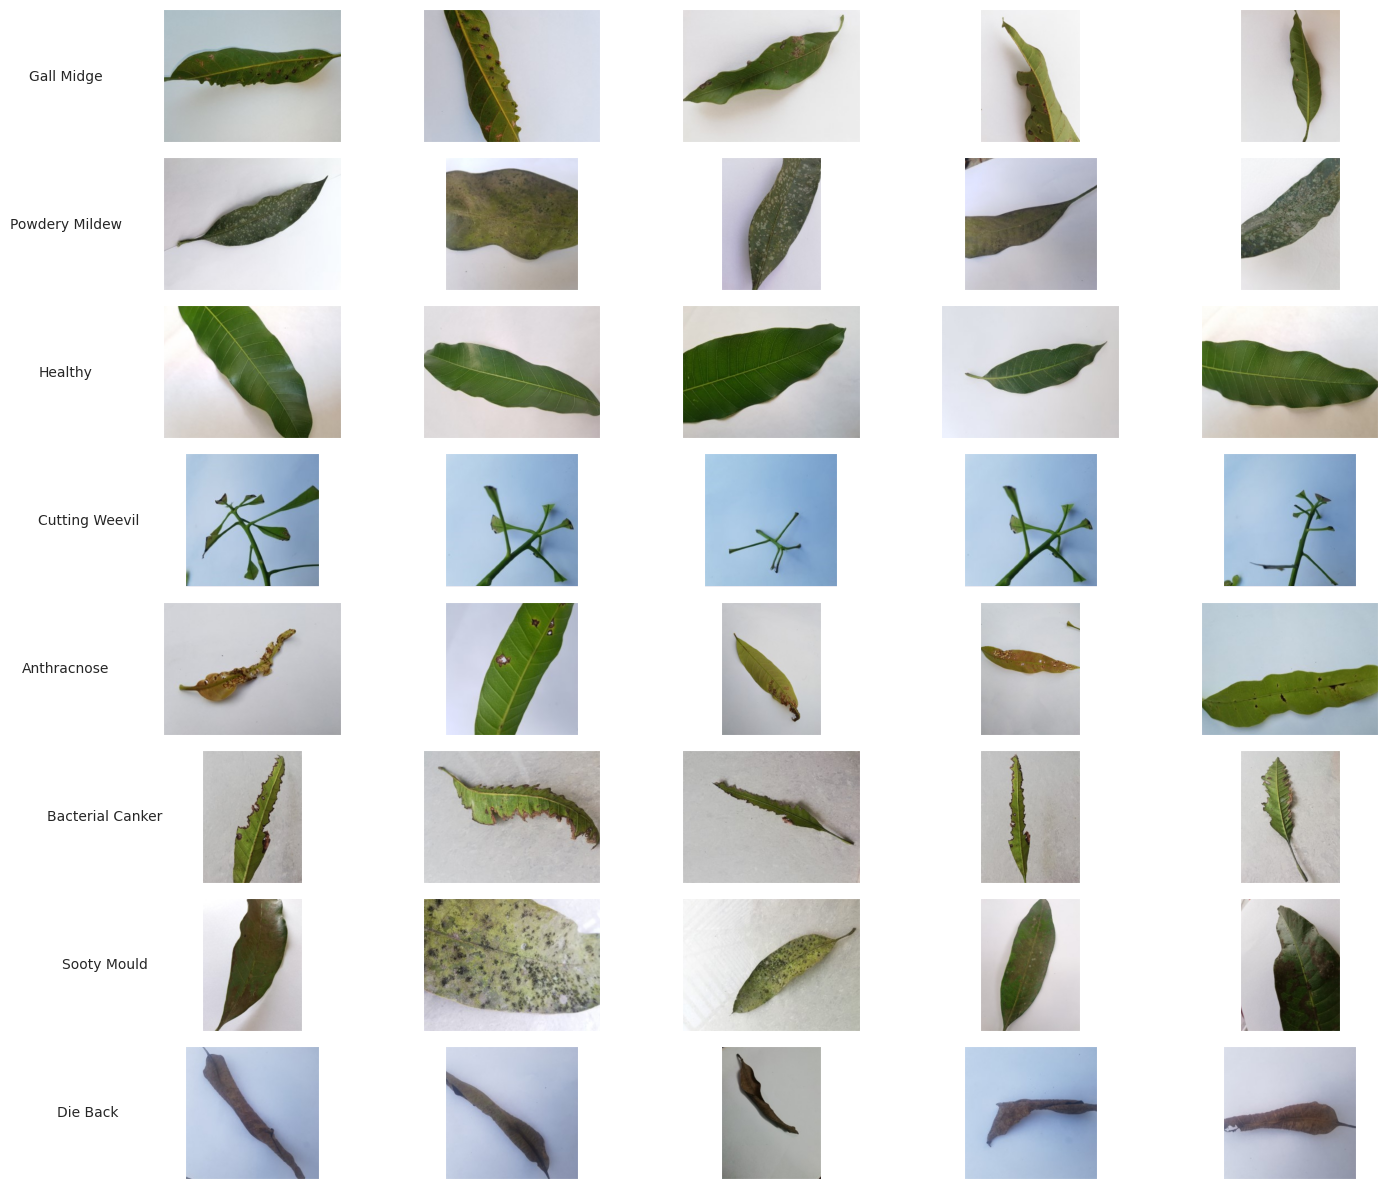

In [12]:
# Membuat kamus untuk menyimpan daftar nama file gambar per kelas
tomato_image = {}

# Path ke folder dataset
dataset_path = "mango-leaf-disease-dataset"

# Kumpulkan nama file gambar berdasarkan kelas
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    tomato_image[class_name] = os.listdir(class_path)

# Visualisasi 5 gambar acak dari setiap kelas
fig, axs = plt.subplots(len(tomato_image.keys()), 5, figsize=(15, len(tomato_image) * 1.5))

for i, class_name in enumerate(tomato_image.keys()):
    images = np.random.choice(tomato_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(dataset_path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

        # Hanya beri label di gambar pertama per baris
        if j == 0:
            axs[i, j].set_ylabel(class_name, fontsize=10, rotation=0, labelpad=70, va='center')

fig.tight_layout()
plt.show()

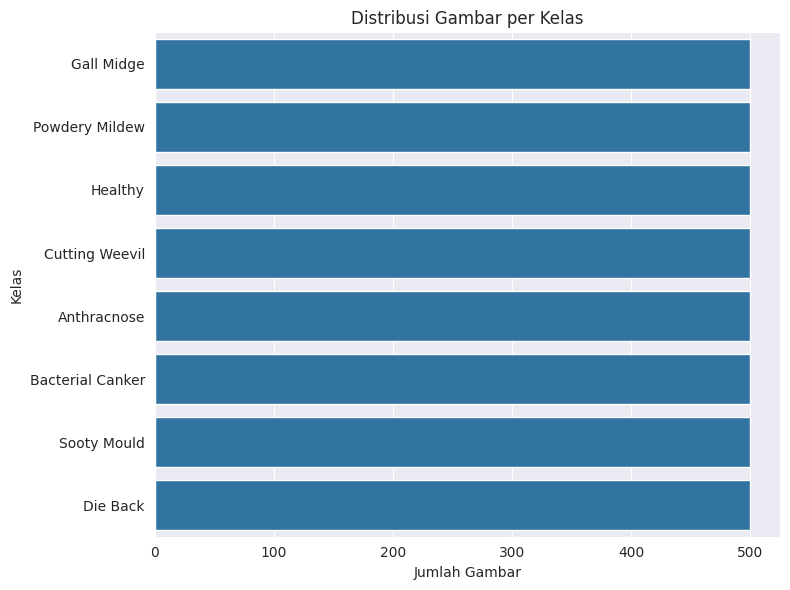

In [13]:
# Define source path
tomato_path = "mango-leaf-disease-dataset"

# Create lists to store file information
file_name = []
labels = []
full_path = []

# Walk through dataset directory
for path, subdirs, files in os.walk(tomato_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))  # Mengambil nama folder sebagai label
        file_name.append(name)

# Create dataframe
distribution_train = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Plot the distribution of images across classes (horizontal)
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.countplot(y="labels", data=distribution_train)
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Jumlah Gambar")
plt.ylabel("Kelas")
plt.tight_layout()
plt.show()

In [14]:
# Menghitung jumlah kelas unik
jumlah_kelas = distribution_train['labels'].nunique()
print(f"Jumlah kelas: {jumlah_kelas}")

# Menghitung total jumlah gambar (semua data)
total_data = len(distribution_train)
print(f"\nTotal jumlah data gambar: {total_data}")

# Menghitung jumlah gambar di setiap kelas
jumlah_per_kelas = distribution_train['labels'].value_counts()
print("\nJumlah gambar per kelas:")
print(jumlah_per_kelas)

Jumlah kelas: 8

Total jumlah data gambar: 4000

Jumlah gambar per kelas:
labels
Gall Midge          500
Powdery Mildew      500
Healthy             500
Cutting Weevil      500
Anthracnose         500
Bacterial Canker    500
Sooty Mould         500
Die Back            500
Name: count, dtype: int64


### Data Preprocessing

#### Split Dataset

In [15]:
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

#### Data Pipeline

In [16]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended: use a custom function for test data batch size, or use a normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# This function will be used in the image data generator for data augmentation; it simply takes the image and returns it.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function=scalar)
ts_gen = ImageDataGenerator(preprocessing_function=scalar)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

# Note: we will use a custom test_batch_size and make shuffle=False
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 3200 validated image filenames belonging to 8 classes.
Found 480 validated image filenames belonging to 8 classes.
Found 320 validated image filenames belonging to 8 classes.


In [20]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Determine the number of classes in the dense layer
class_count = len(list(train_gen.class_indices.keys()))

In [46]:
print(train_gen.class_indices)

{'Anthracnose': 0, 'Bacterial Canker': 1, 'Cutting Weevil': 2, 'Die Back': 3, 'Gall Midge': 4, 'Healthy': 5, 'Powdery Mildew': 6, 'Sooty Mould': 7}


## Modelling

In [41]:
# Here, we'll use ResNet50 from the ResNet family.
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
)

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, None, None,     │    23,587,712 │
│                                 │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,122,504 (92.02 MB)

 Trainable params: 530,696 (2.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [42]:
batch_size = 16   # set batch size for training
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.7284 - loss: 15.6150 - val_accuracy: 0.9292 - val_loss: 7.2181
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.9007 - loss: 6.9034 - val_accuracy: 0.9750 - val_loss: 5.5091
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9003 - loss: 5.2726 - val_accuracy: 0.9812 - val_loss: 4.1623
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.8971 - loss: 4.0166 - val_accuracy: 0.9875 - val_loss: 3.0951
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.8983 - loss: 3.0620 - val_accuracy: 0.9937 - val_loss: 2.3157
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.8811 - loss: 2.4016 - val_accuracy: 0.9958 - val_loss: 1.7755
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.8794 - loss: 1.9303 - val_accuracy: 0.9937 - val_loss: 1.4092
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.8914 - loss: 1.5792 -

## Evaluasi dan Visualisasi

### Visualisasi

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.9929 - loss: 3.0576


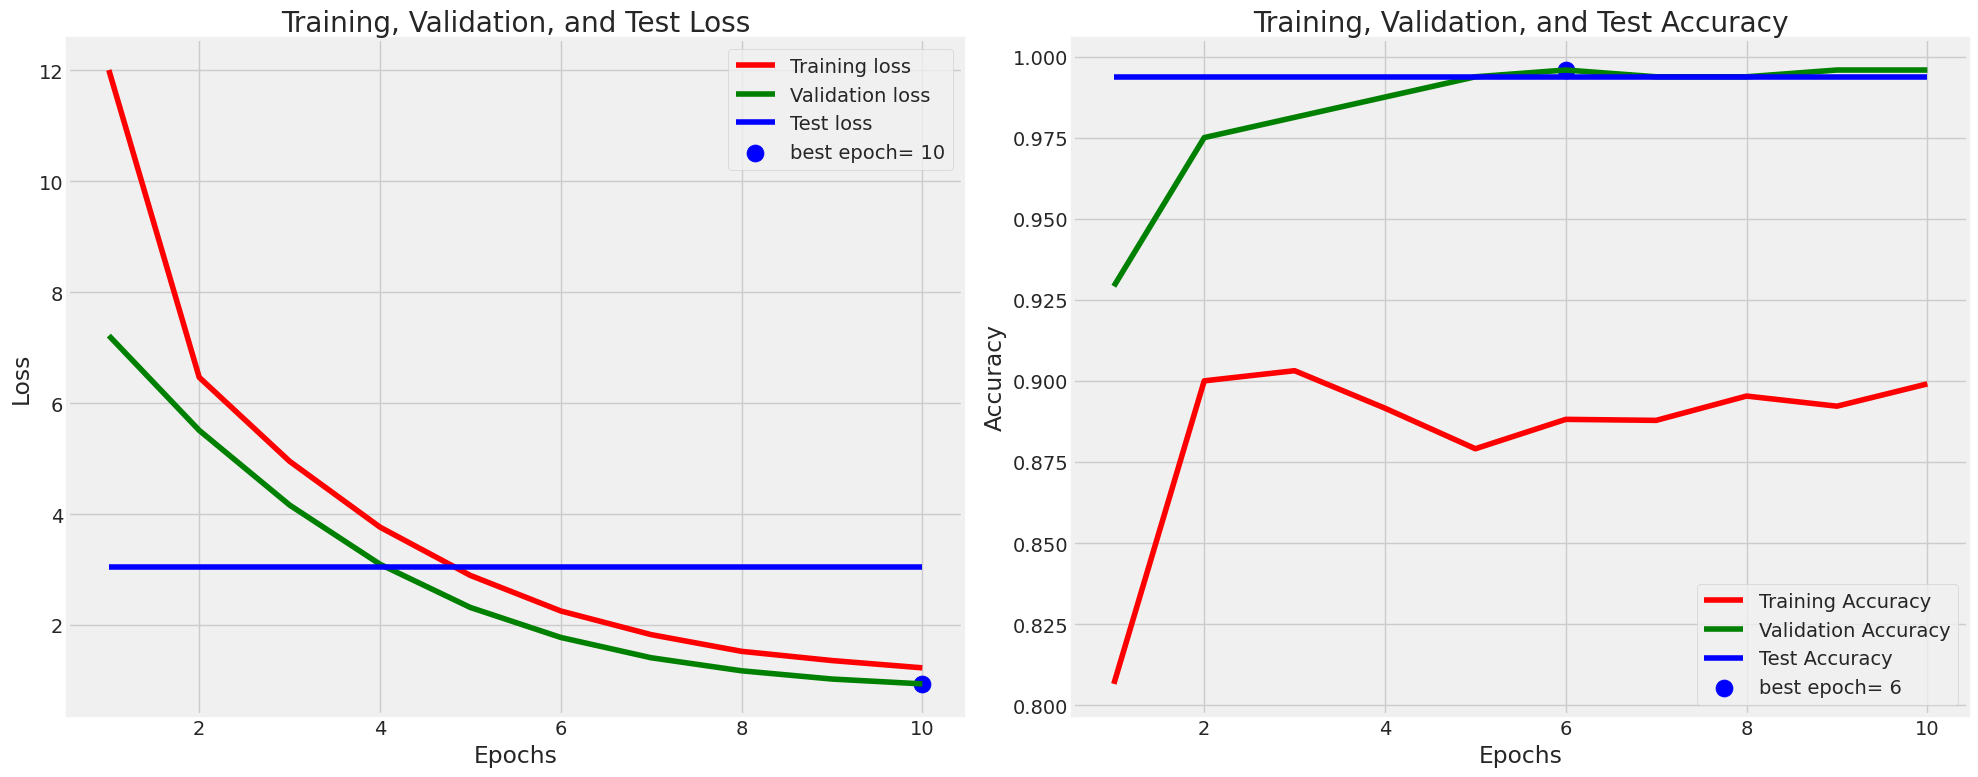

In [44]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

test_loss, test_acc = model.evaluate(test_gen, steps=test_steps)

test_loss_list = [test_loss] * len(Epochs)
test_acc_list = [test_acc] * len(Epochs)

# Plot training history
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.plot(Epochs, test_loss_list, 'b', label='Test loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.plot(Epochs, [test_acc] * len(Epochs), 'b', label='Test Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluasi

In [43]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.8957
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9708 - loss: 0.9558
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.9929 - loss: 3.0576
Train Loss:  0.8994975686073303
Train Accuracy:  1.0
--------------------
Validation Loss:  0.9492756128311157
Validation Accuracy:  0.984375
--------------------
Test Loss:  3.0388245582580566
Test Accuracy:  0.9937499761581421


In [26]:
preds = model.predict(test_gen, steps=test_steps, verbose=1)
y_pred = np.argmax(preds, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step


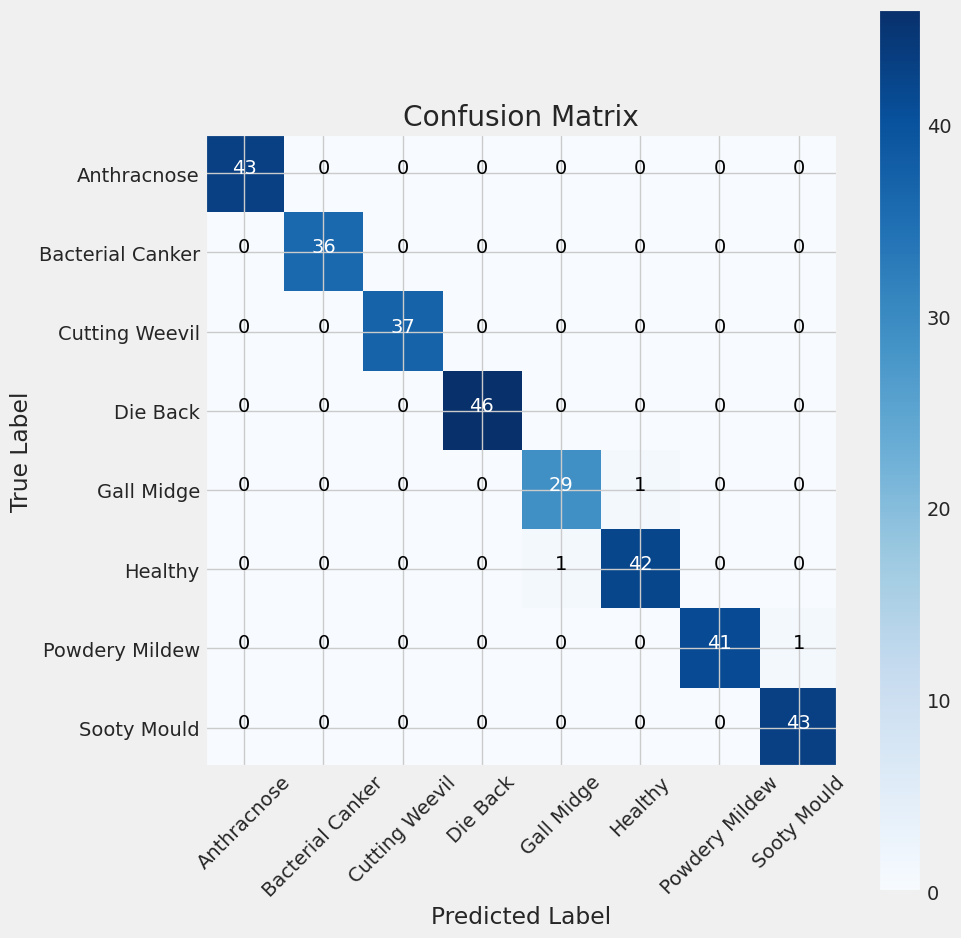

In [28]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [35]:
model.save('model.keras')  # simpan ke file .keras